# Simulation of Poisson Regression

## Import Libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Generate Synthetic Data

In [2]:
def lambda_t(t, w):
    """
    Piecewise linear definition of λ(t; w) according to the description:
    - High in [8, 9]
    - Decreasing in [9, 12]
    - Constant in [12, 15]
    - Increasing in [15, 17]
    - Peak in [17, 18]
    """
    if 8 < t <= 9:
        return np.exp(w[0] + w[1] * (t - 8)) 
    elif 9 < t <= 12:
        return np.exp(w[2] + w[3] * (t - 9))
    elif 12 < t <= 15:
        return np.exp(w[4] + w[5] * (t - 12))
    elif 15 < t <= 17:
        return np.exp(w[6] + w[7] * (t - 15))
    elif 17 < t < 18:
        return np.exp(w[8] + w[9] * (t - 17))
    else:
        raise ValueError("Time t is out of bounds [8, 18].")

In [3]:
def generate_synthetic_data(num_points, w):
    t_data = []
    d_data = []
    intervals = [(8, 9), (9, 12), (12, 15), (15, 17), (17, 18)]
    points_per_interval = [int(num_points * (end - start) / 10) for start, end in intervals]
    
    for (start, end), num in zip(intervals, points_per_interval):
        t_values = np.random.uniform(start, end, num)  # Generate uniform t within the interval
        for t in t_values:
            lam = lambda_t(t, w)
            d = np.random.poisson(lam)  # Generate Poisson-distributed d
            t_data.append(t)
            d_data.append(d)
    
    return np.array(t_data), np.array(d_data)

In [4]:
# Example coefficients for λ(t; w)
w = [4.5, -0.5, 4, -0.3, 3, 0, 3, 0.6, 4.2, 0.6]  # Initial parameter vector

# Generate synthetic data
np.random.seed(42)
t_data, d_data = generate_synthetic_data(num_points=500, w=w)

# Sort the data for visualization purposes
sorted_indices = np.argsort(t_data)
t_data = t_data[sorted_indices]
d_data = d_data[sorted_indices]

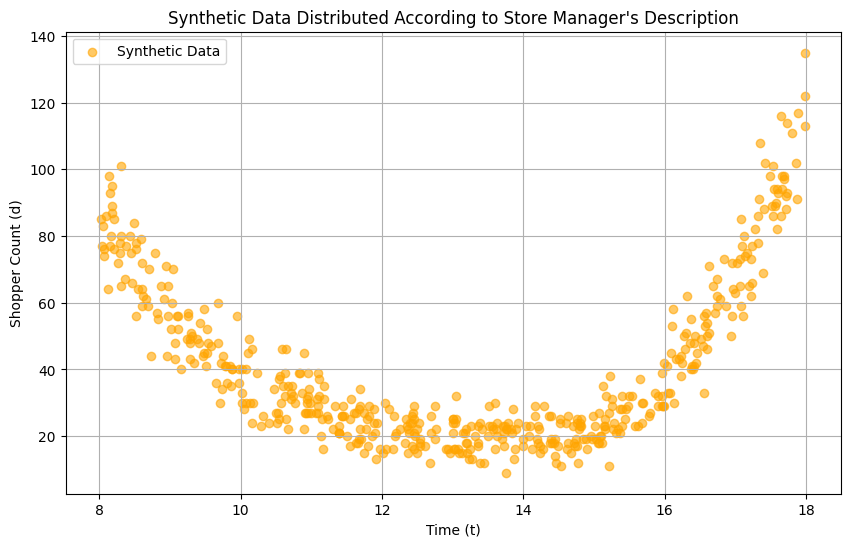

In [5]:
# Plot the synthetic data
plt.figure(figsize=(10, 6))
plt.scatter(t_data, d_data, alpha=0.6, color='orange', label="Synthetic Data")
plt.xlabel("Time (t)")
plt.ylabel("Shopper Count (d)")
plt.title("Synthetic Data Distributed According to Store Manager's Description")
plt.legend()
plt.grid(True)
plt.show()

## Compute Gradients

In [6]:
def gradient(t, w):
    """
    Compute gradients of lambda with respect to w.
    
    Parameters:
        data (list): Observed counts [(t1, d1), (t2, d2), ...].
        w (array): The parameter vector [alpha_01, beta_11, ..., alpha_05, beta_15].
    
    Returns:
        array: Gradients of lambda with respect to w.
    """
    gradients = np.zeros_like(w)
    intervals = [(8, 9), (9, 12), (12, 15), (15, 17), (17, 18)]

    for k, (start, end) in enumerate(intervals):
        grad_alpha = 0
        grad_beta = 0
        if start < t <= end:
            lambda_val = lambda_t(t, w)
            grad_alpha = lambda_val
            grad_beta = (t - start) * lambda_val
        gradients[2 * k] = grad_alpha  # Gradient for alpha_k
        gradients[2 * k + 1] = grad_beta  # Gradient for beta_k
    return gradients

In [7]:
def negative_log_likelihood_and_gradient(w, t_data, d_data):
    nll = 0  # Negative log-likelihood
    grad = np.zeros_like(w)  # Gradient

    for t, d in zip(t_data, d_data):
        lam = lambda_t(t, w)
        nll += -d * np.log(lam) + lam
        grad += ((d / lam) - 1) * gradient(t, w)
    return nll, -grad

## Gradient Descent

In [8]:
def gradient_descent(t_data, d_data, initial_w, learning_rate=0.001, max_iter=100, tol=1e-6):
    w = np.array(initial_w)
    nlls = []
    for i in range(max_iter):
        nll, grad = negative_log_likelihood_and_gradient(w, t_data, d_data)
        w -= learning_rate * grad  # Update parameters
        nlls.append(nll)
        if i % 100 == 0:
            print(f"Epoch {i}, Loss: {nll:.4f}")
        if np.linalg.norm(grad) < tol:  # Convergence check
            print(f"Converged after {i+1} iterations.")
            break
    else:
        print("Gradient descent did not converge within the maximum number of iterations.")
    return w, nlls

In [9]:
def negative_log_likelihood_and_gradient(w, t_data, d_data):
    nll = 0  # Negative log-likelihood
    grad = np.zeros_like(w)  # Gradient

    for t, d in zip(t_data, d_data):
        lam = lambda_t(t, w)
        nll += -d * np.log(lam) + lam
        grad += ((d / lam) - 1) * gradient(t, w)
    return nll, -grad

## Plot Result

Epoch 0, Loss: -20388.2126
Epoch 100, Loss: -57435.7092
Epoch 200, Loss: -57450.5616
Epoch 300, Loss: -57450.6610
Epoch 400, Loss: -57450.6617
Epoch 500, Loss: -57450.6617
Epoch 600, Loss: -57450.6617
Epoch 700, Loss: -57450.6617
Epoch 800, Loss: -57450.6617
Converged after 844 iterations.


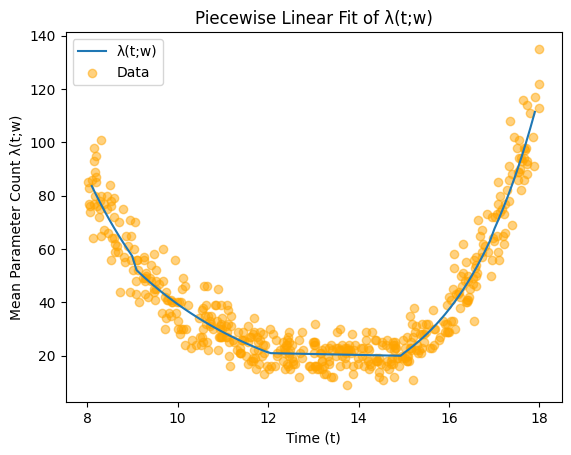

In [13]:
# Initial guess for parameters
np.random.seed(42)
initial_w = np.random.uniform(0.1, 1, 10)

# Perform gradient descent
# NOTES: 
# - increasing n_iter to 1000 causes the nll to increase again after some iterations
# - using max_iter=1000 + learning_rate=0.0001 --> converged after 844 iterations
n_iter = 1000
optimized_w, nlls = gradient_descent(t_data, d_data, initial_w, learning_rate=0.0001, max_iter=n_iter)

# Evaluate the optimized λ(t;w)
t_test = np.linspace(8.1, 17.9, 100)
lambda_test = [lambda_t(t, optimized_w) for t in t_test]

# Plot Mean Count Parameter against Time
plt.plot(t_test, lambda_test, label="λ(t;w)")
plt.scatter(t_data, d_data, alpha=0.5, color='orange', label="Data")
plt.xlabel("Time (t)")
plt.ylabel("Mean Parameter Count λ(t;w)")
plt.title("Piecewise Linear Fit of λ(t;w)")
plt.legend()
plt.show()

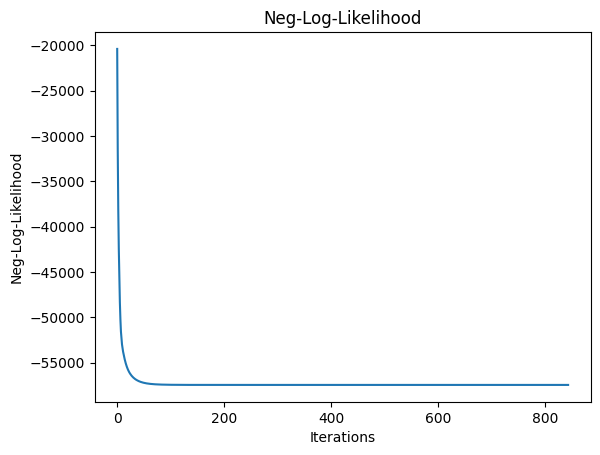

In [11]:
# Plot minimization of Neg-Log-Likelihood
plt.plot(np.arange(0, len(nlls)), nlls)
plt.xlabel("Iterations")
plt.ylabel("Neg-Log-Likelihood")
plt.title("Neg-Log-Likelihood")
plt.show()